In [ ]:
# Dependencies
import os
import cv2
import numpy as np
import pandas as pd
import datetime
import json
import scipy.io as sio
import seaborn as sns

import tifffile
import glob
import imageio
from PIL import Image
from matplotlib import pyplot as plt
from scipy.ndimage import gaussian_filter
import skg

import ProcessingFunctions as pf
import merging_functions as mf

import math
import matplotlib
from matplotlib.colors import LogNorm, Normalize
import copy 

sns.set_style("ticks",{"axes.facecolor": "white"})
plt.rcParams["figure.dpi"] = 200
plt.rcParams["font.family"] = "Calibri"
plt.rcParams['axes.linewidth'] = 0.75

tiny_size = 7
small_size = 7
medium_size = 7
big_size = 7

plt.rc('font', size=small_size)          
plt.rc('axes', titlesize=small_size)    
plt.rc('axes', labelsize=medium_size)    
plt.rc('xtick', labelsize=small_size)    
plt.rc('ytick', labelsize=small_size)    
plt.rc('legend', fontsize=tiny_size)    
plt.rc('figure', titlesize=big_size) 

18.525889911957734 $\mu m$


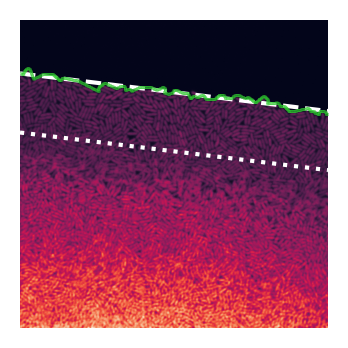

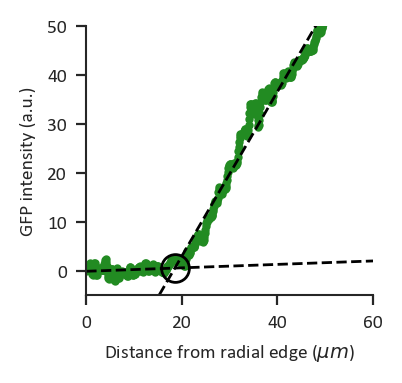

In [4]:

stackFile = "stack.tif"
xvoxel = 0.095
xnum = 1024
#-------------------------------------------------------
#-------------------------------------------------------

# Process Image
projectionImage, smoothImage, outlineImage = pf.processImage(stackFile)

# Get pixels of the colony boundary 
indx = np.where(outlineImage>0)
bndry_x = indx[1]
bndry_y = indx[0]

#-------------------------------------------------------
# Fit a straight line
tmp = np.asarray(bndry_x)
#print(np.std(bndry_x))
if np.std(bndry_x) < 30:
    coeffs = np.polyfit(bndry_y, bndry_x, 1)
    # Create a polynomial function from the coefficients
    p = np.poly1d([1/coeffs[0],-coeffs[1]/coeffs[0]])
    #Parameters of colony boundary line
    m = 1/coeffs[0]

else:
    coeffs = np.polyfit(bndry_x, bndry_y, 1)
    # Create a polynomial function from the coefficients
    p = np.poly1d(coeffs)
    m = coeffs[0]

# Generate x values for plotting the fitted curve
x_fit = np.linspace(0, xnum, 200000)
y_fit = p(x_fit)
#-------------------------------------------------------

dist = []
val = []

max_offset = int(pf.offsetCalc(50/xvoxel,m))

x = np.linspace(0,xnum-1,30000)
c = p(x[0])-x[0]
y = p(x) + max_offset

x = x[(y>0) & (y<xnum-1)]
y = y[(y>0) & (y<xnum-1)]

x = x.astype(int)
y = y.astype(int)

tmp =[]
for i in range(0,x.shape[0]):
    if smoothImage[y[i],x[i]]>30:
        tmp.append(smoothImage[y[i],x[i]])
tmp = np.asarray(tmp)
check_val = np.mean(tmp)

if check_val > 50:
    flag = 0
else:
    flag = 1            

for offset in range(0,max_offset):
    x = np.linspace(0,xnum-1,30000)
    c = p(x[0])-x[0]
    if flag == 0:
        y = p(x) + offset
    elif flag == 1:
        y = p(x) - offset
    
    x = x[(y>0) & (y<xnum-1)]
    y = y[(y>0) & (y<xnum-1)]
    
    x = x.astype(int)
    y = y.astype(int)
    
    tmp =[]
    for i in range(0,x.shape[0]):
        if smoothImage[y[i],x[i]]>30:
            tmp.append(smoothImage[y[i],x[i]])
    tmp = np.asarray(tmp)
    
    dist.append( np.absolute( offset/np.sqrt(1+m*m) )  )
    val.append(np.mean(tmp))
    
dist = xvoxel*np.asarray(dist)
val = np.asarray(val)

dist = dist[val>30]
val = val[val>30]

val = val[dist<60]
dist = dist[dist<60]

dist = dist-dist[0]
val = val-val[0]

coeff_1 = np.polyfit(dist[dist<18],val[dist<18],1)
coeff_2 = np.polyfit(dist[dist>18],val[dist>18],1)
poly_1 = np.poly1d(coeff_1)
poly_2 = np.poly1d(coeff_2)
intersection = [- (coeff_2[1]-coeff_1[1]) / (coeff_2[0]-coeff_1[0]),  
                - (coeff_2[1]*coeff_1[0]-coeff_1[1]*coeff_2[0]) / (coeff_2[0]-coeff_1[0])]

print(str(intersection[0]) + " $\mu m$")

# Plot images
plt.rcParams["figure.figsize"] = (2,2)           
fig,ax = plt.subplots(1,1)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=1, hspace=1)

x_fit = np.linspace(0, xnum, 200000)

#Plot image and fits
ax.imshow(smoothImage)
ax.plot(x_fit,p(x_fit),linestyle="--",color="white")

currOffset = pf.offsetCalc(intersection[0]/xvoxel,m)
if flag == 0:
    ax.plot(x_fit,p(x_fit)+currOffset,linestyle="dotted",color="white")
else:
    ax.plot(x_fit,p(x_fit)-currOffset,linestyle="dotted",color="white")
ax.plot(bndry_x,bndry_y,"o",markersize=0.1,color="limegreen",alpha=0.5)

ax.set_xlim([0,xnum])
ax.set_ylim([xnum,0])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.set_xticks([])
ax.set_yticks([])
ax.tick_params(top=False, bottom=True, left=True, right=False,
            labelleft=True, labelbottom=True, direction="out")

#Plot line fits
plt.rcParams["figure.figsize"] = (1.85,1.75)           
fig,ax = plt.subplots(1,1)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=1, hspace=1)

ax.plot(dist, val, "o", color="forestgreen", markersize=2)
ax.plot(x_fit, poly_1(x_fit), linestyle="--", color="black", linewidth=1)
ax.plot(x_fit, poly_2(x_fit), linestyle="--", color="black", linewidth=1)
ax.plot(intersection[0],intersection[1],"o", color="black", markersize=10,fillstyle="none")


ax.set(xlabel="Distance from radial edge ($\mu m$)", ylabel="GFP intensity (a.u.)")
ax.set_xlim([0,60])
ax.set_ylim([-5,50])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.tick_params(top=False, bottom=True, left=True, right=False,
            labelleft=True, labelbottom=True, direction="out")


C:\Users\HkHer\AppData\Local\Temp\ipykernel_24464\2804173436.py:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  my_cmap = copy.copy(matplotlib.cm.get_cmap('Greys_r'))


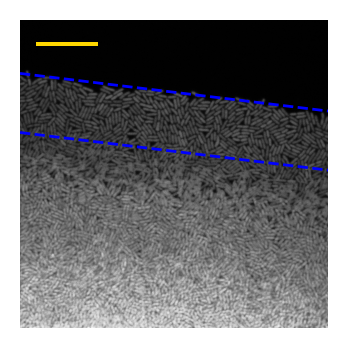

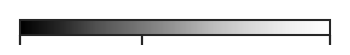

In [5]:
# Plot images
plt.rcParams["figure.figsize"] = (2,2)           
fig,ax = plt.subplots(1,1)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=1, hspace=1)

#Scale bar
xunit = "um"
scalebar_length = 20   # in um
bar_start_coor = (50,70)
bar_end_coor = (int(50 + scalebar_length/xvoxel),90)
bar_thickness = -2
bar_color = (-1,-1,-1)
cv2.rectangle(projectionImage, bar_start_coor, bar_end_coor, bar_color, bar_thickness)

x_fit = np.linspace(0, xnum, 200000)

my_cmap = copy.copy(matplotlib.cm.get_cmap('Greys_r')) 
my_cmap.set_bad((0,0,0))
my_cmap.set_under("gold")

img=ax.imshow(projectionImage,vmin=1e-5, vmax=1*np.amax(projectionImage), cmap=my_cmap)

ax.plot(x_fit,p(x_fit),linestyle="--",color="blue", linewidth=1)
currOffset = pf.offsetCalc(intersection[0]/xvoxel,m)
if flag == 0:
    ax.plot(x_fit,p(x_fit)+currOffset,linestyle="--",color="blue", linewidth=1)
else:
    ax.plot(x_fit,p(x_fit)-currOffset,linestyle="--",color="blue", linewidth=1)
#ax.plot(bndry_x,bndry_y,"o",markersize=0.1,color="limegreen",alpha=0.5)

ax.set_xlim([0,xnum])
ax.set_ylim([xnum,0])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.set_xticks([])
ax.set_yticks([])
ax.tick_params(top=False, bottom=True, left=True, right=False,
            labelleft=True, labelbottom=True, direction="out")

fig, ax = plt.subplots(1,1)
#cax = plt.axes([0.1, 0.2, 0.8, 0.6])
cbar = plt.colorbar(img,orientation="horizontal",ax=ax)
ax.remove()
cbar.set_ticks([0,100,255])
cbar.set_ticklabels([])